In [10]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F #ReLU, LeakyReLU,...
import torch.optim as optim # SGD, ADAM, ....
# from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output
import matplotlib.pyplot as plt


torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)     # On by default, leave it here for clarity

In [28]:
# D:\dataset\pytorch
# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = 'D:/dataset/pytorch/',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
test_set = torchvision.datasets.FashionMNIST(
    root = 'D:/dataset/pytorch/',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=True)

Dataset size: Train => 60000, test => 10000


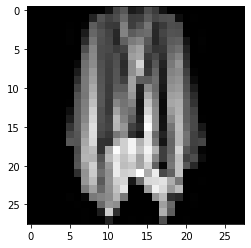

In [20]:
print(f'Dataset size: Train => {len(train_set)}, test => {len(test_set)}')
import PIL
img_t = transforms.ToPILImage()
img = img_t(train_set[5467][0])
plt.imshow(img,cmap="gray")

In [21]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
  def __init__(self):
    super().__init__()

    # define layers
    self.input = nn.Flatten()# 28x28 -> 784
    self.fc1 = nn.Linear(in_features=784, out_features=192)
    self.fc2 = nn.Linear(in_features=192, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    # self.logsoftmax = nn.LogSoftmax(dim=1)

  # define forward function
  def forward(self, t):
    t = self.relu(self.fc1(self.input(t)))
    t = self.relu(self.fc2(t))
    t = self.relu(self.fc3(t))
    
    # output
    t = self.out(t)
    t = self.softmax(t)
    return t

In [22]:
model = Network()
summary(model, (64,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  --                        --
├─Flatten: 1-1                           [64, 784]                 --
├─Linear: 1-2                            [64, 192]                 150,720
├─ReLU: 1-3                              [64, 192]                 --
├─Linear: 1-4                            [64, 120]                 23,160
├─ReLU: 1-5                              [64, 120]                 --
├─Linear: 1-6                            [64, 60]                  7,260
├─ReLU: 1-7                              [64, 60]                  --
├─Linear: 1-8                            [64, 10]                  610
├─Softmax: 1-9                           [64, 10]                  --
Total params: 181,750
Trainable params: 181,750
Non-trainable params: 0
Total mult-adds (M): 11.63
Input size (MB): 0.20
Forward/backward pass size (MB): 0.20
Params size (MB): 0.73
Estimated Total Size (MB): 1.1

In [23]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# define the criterion and optimizer
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0007)
# optimizer = optim.SGD(model.parameters(), lr=0.0007)

In [24]:
model

Network(
  (input): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=192, bias=True)
  (fc2): Linear(in_features=192, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

In [25]:
def train_test(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_epoch_loss += train_batch_loss.cpu().item()
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_epoch_loss = train_epoch_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # make predictions 
                    proba = model(images)
                    # print(proba)
                    # exit(0)
                    # calculate test loss
                    test_batch_loss = loss_fn(proba, labels)
                    test_epoch_loss += test_batch_loss.cpu().item()
                    
                    # get probabilities, extract the class associated with highest probability
                    # proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.cpu().item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    # save epoch losses for plotting
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    # print stats for this epoch
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.5f}, val_loss: {test_epoch_loss:.5f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    # Finally plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 1.63252, val_loss: 1.64962,  val_acc: 81.08%
Epoch: 1 -> train_loss: 1.63161, val_loss: 1.65042,  val_acc: 81.04%
Epoch: 2 -> train_loss: 1.63017, val_loss: 1.65055,  val_acc: 81.10%
Epoch: 3 -> train_loss: 1.62930, val_loss: 1.64836,  val_acc: 81.28%
Epoch: 4 -> train_loss: 1.62841, val_loss: 1.64897,  val_acc: 81.21%
Epoch: 5 -> train_loss: 1.62736, val_loss: 1.64939,  val_acc: 81.08%
Epoch: 6 -> train_loss: 1.62690, val_loss: 1.64962,  val_acc: 81.16%
Epoch: 7 -> train_loss: 1.62593, val_loss: 1.64670,  val_acc: 81.46%
Epoch: 8 -> train_loss: 1.62581, val_loss: 1.64804,  val_acc: 81.34%
Epoch: 9 -> train_loss: 1.62509, val_loss: 1.64652,  val_acc: 81.32%
Epoch: 10 -> train_loss: 1.62470, val_loss: 1.64759,  val_acc: 81.24%
Epoch: 11 -> train_loss: 1.62412, val_loss: 1.64862,  val_acc: 81.14%
Epoch: 12 -> train_loss: 1.62520, val_loss: 1.64714,  val_acc: 81.34%
Epoch: 13 -> train_loss: 1.62315, val_loss: 1.64782,  val_acc: 81.36%
Epoch: 14 -> train_loss: 1.623

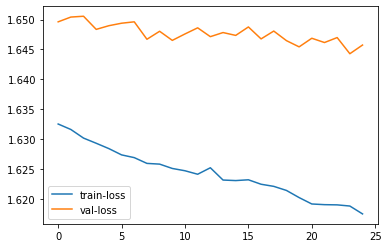

In [29]:
train_test(model, loss_fn, optimizer, train_dl, test_dl, device)